In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir(os.path.join('..', 'dynamic_programming'))
import import_ipynb
from grid_world import standard_grid, negative_grid, ACTION_SPACE
from iterative_policy_evaluation_deterministic import print_policy, print_values

importing Jupyter notebook from grid_world.ipynb
importing Jupyter notebook from iterative_policy_evaluation_deterministic.ipynb


In [2]:
GAMMA = 0.9

In [3]:
def epsilon_greedy(policy, s, eps, grid) :
    if np.random.random() < (1 - eps) :
        return policy[s]
    else :
        random_action = np.random.choice(grid.actions[s])
        return random_action 
        #return np.random.choice(ACTION_SPACE)
    
def play_game(grid, policy, max_steps = 20) :
    s = grid.reset()
    #choose action greedily
    a = epsilon_greedy(policy, s, 0.1, grid)
    
    states = [s]
    rewards = [0]
    actions = [a]
    count = 0
    while not grid.game_over() and count < max_steps :
        r = grid.move(a)
        s = grid.current_state()
        
        #update
        rewards.append(r)
        states.append(s)
        
        if not grid.is_terminal(s) :
            a = epsilon_greedy(policy, s, 0.1, grid)
            actions.append(a)
        count += 1
        
    return states, rewards, actions    

Rewards
+---+---+---+----+
| 0 | 0 | 0 |  1 |
+---+---+---+----+
| 0 | 0 | 0 | -1 |
+---+---+---+----+
| 0 | 0 | 0 |  0 |
+---+---+---+----+
Initial Policy
+---+---+---+---+
| R | L | L |   |
+---+---+---+---+
| D |   | R |   |
+---+---+---+---+
| R | R | L | L |
+---+---+---+---+
Final Policy
+---+---+---+---+
| R | R | R |   |
+---+---+---+---+
| U |   | U |   |
+---+---+---+---+
| U | L | L | L |
+---+---+---+---+
Values
+-------+-------+-------+-------+
| 0.793 | 0.891 | 1.000 | 0.000 |
+-------+-------+-------+-------+
| 0.706 | 0.000 | 0.000 | 0.000 |
+-------+-------+-------+-------+
| 0.628 | 0.538 | 0.354 | 0.000 |
+-------+-------+-------+-------+


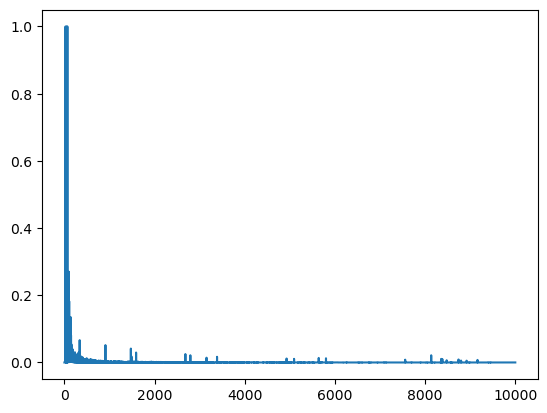

In [4]:
if __name__ == '__main__' :
    grid = standard_grid()
    
    print('Rewards')
    print_values(grid.rewards, grid)
    
    #initialize random policy
    policy = {}
    for k, v in grid.actions.items() :
        policy[k] = np.random.choice(v)
        
    print('Initial Policy')
    print_policy(policy, grid)
    
    Q = pd.DataFrame([], index=grid.actions.keys(), columns = ACTION_SPACE, dtype=np.float64)
    #returns = {}
    sample_counts = {}
    for state in grid.all_states() :
        sample_counts[state] = {} 
        for a in ACTION_SPACE :
            sample_counts[state][a] = 0
            if not grid.is_terminal(state) :
                if a in grid.actions[state] :
                    Q.loc[state, a] = 0
                else :
                    Q.loc[state, a] = 0
            else :
                Q.loc[state, a] = 0
    
    all_states = list(grid.actions.keys())
    
    deltas = []
    #loop until convergence
    for i in range(10000) :
        states, rewards, actions = play_game(grid, policy, max_steps=20)
        states_actions = list(zip(states, actions))
        
        biggest_change = 0
        G = 0
        for t in range(len(rewards) - 2, -1, -1) :
            G = rewards[t + 1] + GAMMA * G
            s_t = states[t]
            a_t = actions[t]
            
            if (s_t, a_t) not in states_actions[:t]:
                old_q = Q.loc[s_t, a_t]
                sample_counts[s_t][a_t] += 1
                lr = 1 / sample_counts[s_t][a_t]
                Q.loc[s_t, a_t] = old_q + lr * (G - old_q)
                max_ = Q.loc[s_t, :].max()
                action_idx = np.random.choice(np.where(Q.loc[s_t, :].values == max_)[0])
                policy[s_t] = ACTION_SPACE[action_idx]
                
                biggest_change = np.max([biggest_change, np.abs(old_q - Q.loc[s_t, a_t])])
        deltas.append(biggest_change)
    
    plt.plot(deltas)
    print('Final Policy')
    print_policy(policy, grid)
    
    V = {}
    for i, row in Q.iterrows():
        V[i] = np.max(row)
    print('Values')
    print_values(V, grid)

In [5]:
Q

U         D         L         R
0 0  0.000000  0.617815  0.000000  0.793188
  1  0.000000  0.000000  0.705121  0.890508
  2  0.000000  0.000000  0.791245  1.000000
1 0  0.705572  0.544210  0.000000  0.000000
  2  0.000000  0.000000  0.000000 -1.000000
2 0  0.627797  0.025965 -0.010295  0.457147
  1  0.054051 -0.031381  0.537616  0.211767
  2 -0.300000  0.000000  0.354161 -0.128571
  3 -1.000000  0.000000  0.000000  0.000000
0 3  0.000000  0.000000  0.000000  0.000000
1 3  0.000000  0.000000  0.000000  0.000000

In [6]:
policy

{(0, 0): 'R',
 (0, 1): 'R',
 (0, 2): 'R',
 (1, 0): 'U',
 (1, 2): 'U',
 (2, 0): 'U',
 (2, 1): 'L',
 (2, 2): 'L',
 (2, 3): 'L'}